# NLP

NLP trata de aplicaciones que entiendan nuestro idioma, reconocimiento de voz, traducción, comprensión semántica, análisis de sentimiento..

**Usos**

+ Motores de búsqueda
+ Feed de redes sociales
+ Asistentes de voz 
+ Filtros de span
+ Chatbots

**Librerías**

+ NLTK
+ Spacy
+ TFIDF
+ OpenNLP

La dificultad del NLP está en varios niveles:

+ Ambigüedad:

  * Nivel léxico: por ejemplo, varios significados
  * Nivel referencial: anáforas, metáforas, etc...
  * Nivel estructural: la semántica es necesaria para entender la estructura de una oración
  * Nivel pragmático: dobles sentidos, ironía, humor
  
+ Detección de espacios
+ Recepción imperfecta: acentos, -ismos, OCR

El proceso es similar que en USL, primero se vectorizan las palabras y después se miden sus distancias/similitudes. 

In [1]:
# lista de 100 peliculas

titles=open('data/title_list.txt').read().split('\n')[:100]

titles[:15]

['The Godfather',
 'The Shawshank Redemption',
 "Schindler's List",
 'Raging Bull',
 'Casablanca',
 "One Flew Over the Cuckoo's Nest",
 'Gone with the Wind',
 'Citizen Kane',
 'The Wizard of Oz',
 'Titanic',
 'Lawrence of Arabia',
 'The Godfather: Part II',
 'Psycho',
 'Sunset Blvd.',
 'Vertigo']

In [2]:
synopsis=open('data/synopses_list.txt').read().split('\n BREAKS HERE')[:100]

synopsis[0][:200]

" Plot  [edit]  [  [  edit  edit  ]  ]  \n  On the day of his only daughter's wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito's youngest son,"

### Limpieza

In [3]:
#!pip3 install spacy

In [4]:
import string
import spacy

from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

import re

In [5]:
nlp=spacy.load('en')

parser=English()

In [6]:
def spacy_tokenizer(sentence):
    
    tokens=parser(sentence)
    
    filtered_tokens=[]
    for word in tokens:
        lemma=word.lemma_.lower().strip()
        
        if lemma not in STOP_WORDS and re.search('^[a-zA-Z]+$', lemma):
            filtered_tokens.append(lemma)
            
    return filtered_tokens

In [7]:
spacy_tokenizer(synopsis[0][:200])

['plot',
 'edit',
 'edit',
 'edit',
 'day',
 'daughter',
 'wedding',
 'vito',
 'corleone',
 'hears',
 'requests',
 'role',
 'godfather',
 'don',
 'new',
 'york',
 'crime',
 'family',
 'vito',
 'youngest',
 'son']

### TFIDF (term frequency inverse document frequency)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
tfidf=TfidfVectorizer(min_df=.15, tokenizer=spacy_tokenizer)

In [10]:
tfidf_matrix=tfidf.fit_transform(synopsis)

In [11]:
tfidf_matrix.shape

(100, 254)

In [12]:
tfidf_matrix

<100x254 sparse matrix of type '<class 'numpy.float64'>'
	with 6489 stored elements in Compressed Sparse Row format>

In [13]:
import pandas as pd
pd.DataFrame(tfidf_matrix).head()

,0
0,"(0, 171)\t0.015782503757703084\n (0, 53)\t0..."
1,"(0, 171)\t0.016707243705417485\n (0, 53)\t0..."
2,"(0, 171)\t0.017879690869526076\n (0, 53)\t0..."
3,"(0, 171)\t0.012541408775298609\n (0, 53)\t0..."
4,"(0, 171)\t0.016972872543944847\n (0, 53)\t0..."


In [14]:
terms=tfidf.get_feature_names()
terms[:15]

['able',
 'agrees',
 'air',
 'american',
 'apartment',
 'army',
 'arrive',
 'arrives',
 'asks',
 'attack',
 'attempt',
 'attempts',
 'attention',
 'away',
 'battle']

### Distancias

In [15]:
from sklearn.metrics.pairwise import cosine_similarity as cos

In [16]:
dist=1-cos(tfidf_matrix)

dist.shape

(100, 100)

### Clustering

In [17]:
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

import numpy as np

In [18]:
from umap import UMAP

In [19]:
umap=UMAP(n_neighbors=5, random_state=42)
emb=umap.fit_transform(dist)

In [20]:
emb[:5]

array([[-1.4891616 ,  4.0788736 ],
       [-1.7629136 ,  0.16342701],
       [-4.7745385 ,  2.5759263 ],
       [-0.6867237 ,  0.73427945],
       [-0.8975087 ,  2.8176866 ]], dtype=float32)

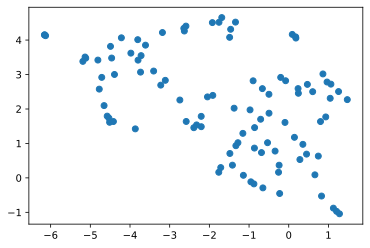

In [22]:
plt.scatter(emb[:,0], emb[:,1]);

In [23]:
from hdbscan import HDBSCAN

In [24]:
hdbscan=HDBSCAN(min_cluster_size=5)

clusters=hdbscan.fit_predict(emb)

In [25]:
np.unique(clusters)

array([-1,  0,  1,  2,  3])

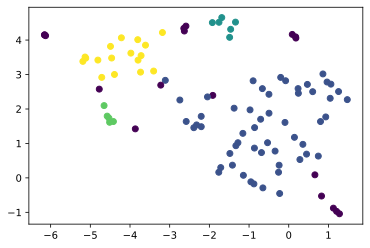

In [26]:
plt.scatter(emb[:,0], emb[:,1], c=clusters);

### titutlos de los clusters

In [27]:
def get_titles_from_cluster(c):
    return pd.Series(titles)[clusters==c]

In [34]:
get_titles_from_cluster(2)

37                            Unforgiven
49                                  Jaws
52    Butch Cassidy and the Sundance Kid
53      The Treasure of the Sierra Madre
56                             High Noon
dtype: object

In [35]:
tfidf_df=pd.DataFrame(tfidf_matrix.toarray(), columns=terms)

tfidf_df.head()

,able,agrees,air,american,apartment,army,arrive,arrives,asks,attack,...,window,woman,work,working,world,wounded,year,years,york,young
0,0.0,0.064639,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.053967,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.07811,0.062870,0.159100,0.0
1,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.074787,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.091133,0.073637,0.0,0.00000,0.133108,0.000000,0.0
2,0.0,0.073228,0.000000,0.000000,0.0,0.121965,0.000000,0.146456,0.061139,0.0,...,0.0,0.0,0.000000,0.000000,0.197012,0.0,0.00000,0.000000,0.000000,0.0
3,0.0,0.000000,0.069901,0.089895,0.0,0.085550,0.000000,0.000000,0.128654,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.06207,0.000000,0.189641,0.0
4,0.0,0.069514,0.000000,0.081106,0.0,0.077186,0.075976,0.000000,0.000000,0.0,...,0.0,0.0,0.079747,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0


In [36]:
tfidf_df.shape

(100, 254)

In [37]:
def get_df_from_cluster(c):
    return tfidf_df[clusters==c]

In [39]:
get_df_from_cluster(3).head()

,able,agrees,air,american,apartment,army,arrive,arrives,asks,attack,...,window,woman,work,working,world,wounded,year,years,york,young
10,0.0,0.000000,0.000000,0.074369,0.0,0.176937,0.000000,0.0,0.053217,0.077024,...,0.0,0.0,0.000000,0.000000,0.171486,0.000000,0.0,0.000000,0.0,0.0
19,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.172417,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
24,0.0,0.000000,0.000000,0.000000,0.0,0.103461,0.067893,0.0,0.103726,0.000000,...,0.0,0.0,0.213789,0.082732,0.100274,0.238274,0.0,0.000000,0.0,0.0
29,0.0,0.000000,0.325392,0.000000,0.0,0.168951,0.047515,0.0,0.000000,0.315204,...,0.0,0.0,0.000000,0.057900,0.046784,0.000000,0.0,0.042284,0.0,0.0
31,0.0,0.074873,0.101893,0.087359,0.0,0.083137,0.000000,0.0,0.062512,0.226194,...,0.0,0.0,0.085895,0.000000,0.000000,0.191465,0.0,0.000000,0.0,0.0


In [40]:
get_df_from_cluster(3).T.head()

,10,19,24,29,31,33,34,36,38,48,50,55,57,61,62,79,88
able,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.061875,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.061057,0.0,0.000000,0.000000
agrees,0.000000,0.0,0.0,0.000000,0.074873,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.045844,0.0,0.000000,0.064563
air,0.000000,0.0,0.0,0.325392,0.101893,0.0,0.000000,0.000000,0.119018,0.000000,0.0,0.145862,0.000000,0.062387,0.0,0.084522,0.000000
american,0.074369,0.0,0.0,0.000000,0.087359,0.0,0.000000,0.354101,0.000000,0.235823,0.0,0.062528,0.190484,0.133720,0.0,0.000000,0.000000
apartment,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


In [46]:
top_words_cluster=get_df_from_cluster(3).T.sum(axis=1).sort_values(ascending=False)

top_words_cluster.head()

army        2.727777
general     2.264080
soldiers    2.253071
battle      2.033972
war         2.028721
dtype: float64

## NLP_es 

In [47]:
#!python3 -m spacy download es_core_news_md

In [48]:
nlp=spacy.load('es_core_news_md')

In [49]:
doc2vec=nlp('hola me llamo Pepe').vector.sum()

In [50]:
word2vec=(nlp('hola').vector+nlp('me').vector+nlp('llamo').vector+nlp('Pepe').vector).sum()/4

In [51]:
doc2vec

3.9176705

In [52]:
word2vec

3.917670488357544

##### similitud

In [53]:
nlp('quiero saludar a todos los alumnos de ironhack').similarity(nlp('quiero dar saludos'))

0.8303984204423167

In [54]:
tokens_1=spacy_tokenizer('quiero saludar a todos')
tokens_2=spacy_tokenizer('saludar al perro')

In [55]:
def get_simil(t1, t2):
    return nlp(' '.join(t1)).similarity(nlp(' '.join(t2)))

In [56]:
get_simil(tokens_1, tokens_2)

0.8416365657002934

# WordClouds

In [57]:
# librerias

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
# !python3 -m spacy download en
from spacy.lang.es import Spanish
# !python3 -m spacy download es_core_news_md


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words_sp=set(stopwords.words('spanish'))
stop_words_en=set(stopwords.words('english'))
stop_words=stop_words_sp | stop_words_en


import re

from langdetect import detect

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /Users/data/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:
def tokenizer(txt):  # texto
    
    if detect(txt)=='en':    # si el texto esta en ingles...
        nlp=spacy.load('en')
        parser=English()
        
    elif detect(txt)=='es':   # si el texto esta en castellano...
        nlp=spacy.load('es_core_news_md')
        parser=Spanish()
        
    else:
        return 'No es castellano ni ingles.'
    
    tokens=parser(txt)
    
    filtered_tokens=[]
    
    for word in tokens:
        lemma=word.lemma_.lower().strip()
        if lemma not in STOP_WORDS and re.search('^[a-zA-Z]+$', lemma):
            filtered_tokens.append(lemma)
    
    return ' '.join(filtered_tokens)